
# The impact of CEO turnover on company culture

### William Zhu (wzhu4@uchicago.edu)



This file (final_4.ipynb) covers section 4.

## 0. Importing packages

In [1]:
#Special module written for content analysis
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition
from sklearn.ensemble import AdaBoostClassifier

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp
plt.style.use('fivethirtyeight')
import matplotlib.cm #Still for graphics
import matplotlib.patches as mpatches
import seaborn #Makes the graphics look nicer
import spacy
import nltk

#%matplotlib inline

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

Importing data

In [3]:
df = pandas.read_csv('clean_df.csv', index_col=0)

In [4]:
df.head()

,ID,text,category,year,cat_id,tokenized_text,normalized_tokens
0,1,Best Company to work for People are smart and ...,google,2018,2,"['Best', 'Company', 'to', 'work', 'for', 'Peop...","['well', 'company', 'work', 'people', 'smart',..."
1,2,"Moving at the speed of light, burn out is inev...",google,2013,2,"['Moving', 'at', 'the', 'speed', 'of', 'light'...","['move', 'speed', 'light', 'burn', 'inevitable..."
2,3,Great balance between big-company security and...,google,2014,2,"['Great', 'balance', 'between', 'big', 'compan...","['great', 'balance', 'big', 'company', 'securi..."
3,4,The best place I've worked and also the most d...,google,2015,2,"['The', 'best', 'place', 'I', ""'ve"", 'worked',...","['well', 'place', 'have', 'work', 'demand', 'f..."
4,10,Execellent for engineers Impact driven. Best t...,google,2018,2,"['Execellent', 'for', 'engineers', 'Impact', '...","['execellent', 'engineer', 'impact', 'drive', ..."


## 4. Classification

In [5]:
#only keep the 4 years of review
keep = [2012, 2013, 2016, 2017]
df = df.loc[df['year'].isin(keep)]

# category = True if the review is from 2016 or 2017
# category = False if the review is from 2012 or 2013
df['category'] = [s > 2014 for s in df['year']]

In [6]:
# Create 6 datasets
df0 = df[df['cat_id']==0].reset_index()
df1 = df[df['cat_id']==1].reset_index()
df2 = df[df['cat_id']==2].reset_index()
df3 = df[df['cat_id']==3].reset_index()
df4 = df[df['cat_id']==4].reset_index()
df5 = df[df['cat_id']==5].reset_index()

In [7]:
# Amazon - no CEO change before 2018 (Jeff Bezos)
df0['year'].value_counts()

2017    6678
2016    4039
2013     784
2012     453
Name: year, dtype: int64

In [8]:
# Netflix - No CEO change before 2018 (Reed Hastings)
df1['year'].value_counts()

2017    94
2016    83
2013    55
2012    45
Name: year, dtype: int64

In [9]:
# Google - Eric Schmidt to 2011. Larry Page from 2011 to 2015
# Sundar Pichai from 2015 onward
df2['year'].value_counts()

2017    1298
2016    1186
2013     394
2012     272
Name: year, dtype: int64

In [10]:
# Apple - Steve Jobs before 2009, periodic medical leave until resignation in 2011. Tim Cook (acting CEO in 2009, CEO in 2011)
df3['year'].value_counts()

2016    2410
2017    2207
2013     793
2012     395
Name: year, dtype: int64

In [11]:
# Facebook No CEO change before 2018 (Mark Zuckerberg)
df4['year'].value_counts()

2017    321
2016    242
2012    184
2013     74
Name: year, dtype: int64

In [12]:
# Microsoft Steve Ballmer before 2014. Satya Nadella since 2014
df5['year'].value_counts()


2016    2626
2017    2364
2013    1559
2012    1238
Name: year, dtype: int64

For this study, I will mainly focus on two CEO turnovers:

1. Google (df2) 2015

2. Microsoft (df5) 2014

Since they all happend in 2014-2015, I will use 2012, 2013 reviews as pre, 2016, 2017 as post.

Control Groups:
(pre: 2012, 2013. Post: 2016, 2017)

1. Amazon (df0)

2. Netflix (df1)

3. Facebook (df4)

4. Apple (df3)

Hypothesis: If CEO has big impact on company reviews, I predict good classification prediction results for treatment groups. Bad classification prediction results for control groups.

In [13]:
#Bayes
clf1 = sklearn.naive_bayes.BernoulliNB()

#SVM
clf2 = sklearn.svm.SVC(kernel = 'linear', probability = False, random_state=123) #slow, set probability = False to speed up

# KNN
clf3 = sklearn.neighbors.KNeighborsClassifier(2, weights='distance')# k, 'distance' or 'uniform'

#Logistic Regression
clf4 = sklearn.linear_model.LogisticRegression(penalty='l2')

#Random Forest
clf5 = sklearn.ensemble.RandomForestClassifier(random_state=123)

#Neural Network
clf6 = sklearn.neural_network.MLPClassifier(random_state=123)

#Gradient boosting
clf7 = sklearn.ensemble.GradientBoostingClassifier(random_state=123)

#Ada Boost
clf8 = AdaBoostClassifier(random_state=123)

models = [clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8]

1. Google (df2) 2015

In [14]:
def data_prep(df):
    #To make sure that the True-False ratio is 50-50, sample the large group with the size of the smaller group.
    lim = min(len(df[df['category']==False]), 1000)

    df = df.groupby('category').apply(lambda x: x.sample(lim, random_state=123) if len(x) > lim else x).reset_index(drop=True)
    df['tokenized_text'] = df['text'].apply(lambda x: lucem_illud.word_tokenize(x))
    df['normalized_text'] = df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))
    return df

In [15]:
def data_split(df):
    holdBackFraction = .3
    train_data_df, test_data_df = lucem_illud.trainTestSplit(df, holdBackFraction=holdBackFraction)
    TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
    TFVects = TFVectorizer.fit_transform([' '.join(l) for l in train_data_df['normalized_text']])

    train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

    TFVects_test = TFVectorizer.transform([' '.join(l) for l in test_data_df['normalized_text']])
    test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]
    return (train_data_df, test_data_df, TFVectorizer)

In [2]:
#create a helper function to fit all models and show results together
def fit_helper(train_test_df):
    pred_ls = []
    train = train_test_df[0]
    test = train_test_df[1]
    for model in models:
        model.fit(np.stack(train['vect'], axis=0), train['category'])
        pred_ls.append(model.score(np.stack(test['vect'], axis=0), test['category']))
    return pred_ls

In [16]:
def get_prediction(df):
    train_test_split = data_split(data_prep(df))
    ls = fit_helper(train_test_split)
    return ls

In [17]:
df0_pd = get_prediction(df0)
df1_pd = get_prediction(df1)
df2_pd = get_prediction(df2)
df3_pd = get_prediction(df3)
df4_pd = get_prediction(df4)
df5_pd = get_prediction(df5)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [18]:
df_pd = [df2_pd,
        df5_pd,
        df0_pd,
        df1_pd,
        df3_pd,
        df4_pd]

In [19]:
df_table = pandas.DataFrame(data=df_pd, 
                    index = ['Google',
                            'Microsoft',
                            'Amazon',
                            'Netflix',
                            'Apple',
                            'Facebook'],
                    columns = ['Naive Bayes',
                            'SVM',
                            'KNN',
                            'Logit',
                            'Random Forest',
                            'Neural Network',
                            'Gradient Boosting',
                            'Ada Boosting']).reset_index()

In [20]:
df_table

,index,Naive Bayes,SVM,KNN,Logit,Random Forest,Neural Network,Gradient Boosting,Ada Boosting
0,Google,0.543860,0.588972,0.541353,0.596491,0.526316,0.536341,0.551378,0.556391
1,Microsoft,0.640000,0.640000,0.505000,0.646667,0.608333,0.631667,0.586667,0.595000
2,Amazon,0.606667,0.631667,0.478333,0.643333,0.621667,0.620000,0.603333,0.591667
3,Netflix,0.733333,0.583333,0.583333,0.550000,0.516667,0.583333,0.500000,0.533333
4,Apple,0.563333,0.565000,0.503333,0.586667,0.558333,0.535000,0.576667,0.598333
5,Facebook,0.616883,0.603896,0.584416,0.597403,0.590909,0.525974,0.584416,0.616883


In [21]:
df_table.to_csv('Prediction_table.csv')

Plot

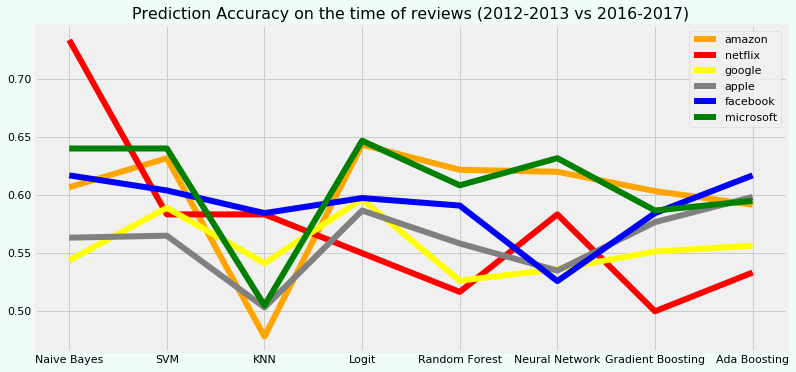

In [39]:
fig = plt.figure(figsize = (12,6))
fig.set_facecolor('#f0fcfa')

plt.rc('font', size=11)

plt.title('Prediction Accuracy on the time of reviews (2012-2013 vs 2016-2017)') 
plt.plot(df_table.loc[2][1:], color ='orange', label = 'amazon', linewidth=6)
plt.plot(df_table.loc[3][1:], color ='red', label = 'netflix', linewidth=6)
plt.plot(df_table.loc[0][1:], color ='yellow', label = 'google', linewidth=6)
plt.plot(df_table.loc[4][1:], color ='gray', label = 'apple', linewidth=6)
plt.plot(df_table.loc[5][1:], color ='blue', label = 'facebook', linewidth=6)
plt.plot(df_table.loc[1][1:], color ='green', label = 'microsoft', linewidth=6)

plt.legend()
plt.savefig('output_4/predictions.png', bbox_inches='tight')

Naive Bayes for Google and Microsoft

Google

In [50]:
df2['year'].value_counts()

2017    1298
2016    1186
2013     394
2012     272
Name: year, dtype: int64

In [51]:
train_df2, test_df2, TFVectorizer= data_split(data_prep(df2))

In [52]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_df2['vect'], axis=0), train_df2['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [53]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'after2014' : [],
    'after2014_log_prob' : [],
    'before2014' : [],
    'before2014_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:10]:
    words_dict['after2014'].append(TFVectorizer.get_feature_names()[i])
    words_dict['after2014_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:10]:
    words_dict['before2014'].append(TFVectorizer.get_feature_names()[i])
    words_dict['before2014_log_prob'].append(prob)
    
pandas.DataFrame(words_dict).to_csv('output_4/google_words.csv')

Microsoft

In [16]:
train_df5, test_df5, TFVectorizer= data_split(data_prep(df5))

In [55]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_df5['vect'], axis=0), train_df5['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [56]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'after2014' : [],
    'after2014_log_prob' : [],
    'before2014' : [],
    'before2014_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:8]:
    words_dict['after2014'].append(TFVectorizer.get_feature_names()[i])
    words_dict['after2014_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:8]:
    words_dict['before2014'].append(TFVectorizer.get_feature_names()[i])
    words_dict['before2014_log_prob'].append(prob)
    
pandas.DataFrame(words_dict).to_csv('output_4/microsoft_words.csv')

Facebook

In [57]:
train_df4, test_df4, TFVectorizer= data_split(data_prep(df4))

naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_df4['vect'], axis=0), train_df4['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [58]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'after2014' : [],
    'after2014_log_prob' : [],
    'before2014' : [],
    'before2014_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:8]:
    words_dict['after2014'].append(TFVectorizer.get_feature_names()[i])
    words_dict['after2014_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:8]:
    words_dict['before2014'].append(TFVectorizer.get_feature_names()[i])
    words_dict['before2014_log_prob'].append(prob)
    
pandas.DataFrame(words_dict).to_csv('output_4/facebook_words.csv')